### Draft

This is the draft so far with some interesting visualizations

In [ ]:
pip install siuba

     |████████████████████████████████| 112 kB 5.0 MB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from plotnine import *
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
from numpy import nan

import os
from numpy import mean, std, absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso, LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import *
from sklearn.metrics import confusion_matrix


from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.model_selection import train_test_split # simple TT split cv

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from siuba.dply.forcats import fct_lump, fct_reorder 

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

from sklearn.metrics import silhouette_score
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
subscribers = pd.read_csv(io.BytesIO(uploaded['subscribers.csv']))
app_activity = pd.read_csv(io.BytesIO(uploaded['app_activity.csv']))

Saving app_activity.csv to app_activity.csv
Saving subscribers.csv to subscribers.csv


In [ ]:
#subscribers = pd.read_csv("subscribers.csv")
#app_activity = pd.read_csv("app_activity.csv")

In [ ]:
subscribers.describe()

,ID,Purchase Amount,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
count,40102.000000,2.692300e+04,28448.000000,28448.000000,28448.000000,28448.000000,28448.000000
mean,19980.310982,3.270582e+08,32.389307,8.233971,2.154246,3.892435,0.362943
std,11550.985627,1.681253e+10,58.436061,37.385582,29.366507,13.137642,1.132356
min,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,9970.250000,0.000000e+00,4.000000,0.000000,0.000000,0.000000,0.000000
50%,19972.500000,3.881000e+01,10.000000,1.000000,0.000000,1.000000,0.000000
75%,29983.750000,1.523900e+02,33.000000,5.000000,0.000000,2.000000,0.000000
max,40000.000000,1.600000e+12,4370.000000,4365.000000,4348.000000,196.000000,44.000000


In [ ]:
app_activity

,ID,App Session Platform,App Activity Type,App Session Date
0,1,ios,App Launch,3/20/2019
1,2,android,App Launch,12/3/2019
2,3,ios,App Launch,5/2/2019
3,4,ios,App Launch,2/6/2020
4,5,ios,Start,9/14/2019
...,...,...,...,...
809473,6098,ios,Other,10/21/2019
809474,13928,ios,Completed,3/12/2019
809475,1113,android,Other,3/29/2020
809476,571,ios,Start,2/10/2020


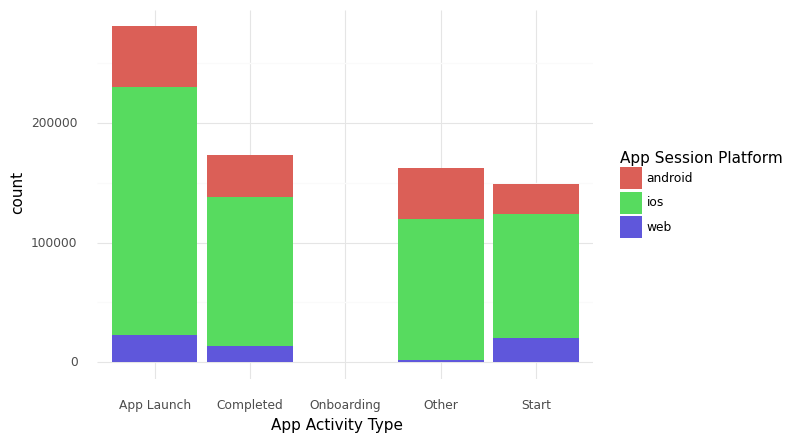

<ggplot: (8789062123257)>

In [ ]:
app_activity = app_activity.dropna()
app_activity["App Session Date"] = 

(ggplot(app_activity, aes(x = "App Activity Type", fill = "App Session Platform")) + geom_bar() + theme_minimal())

In [ ]:
subscribers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40102 entries, 0 to 40101
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       40102 non-null  int64  
 1   Language                 40102 non-null  object 
 2   Subscription Type        40102 non-null  object 
 3   Subscription Event Type  40102 non-null  object 
 4   Purchase Store           40102 non-null  object 
 5   Purchase Amount          26923 non-null  float64
 6   Currency                 26924 non-null  object 
 7   Subscription Start Date  40102 non-null  object 
 8   Subscription Expiration  40102 non-null  object 
 9   Demo User                40102 non-null  object 
 10  Free Trial User          40102 non-null  object 
 11  Free Trial Start Date    5833 non-null   object 
 12  Free Trial Expiration    5833 non-null   object 
 13  Auto Renew               40101 non-null  object 
 14  Country               

Rename and prepare columns for modeling - for binary variables I coded them with a loop but using get_dummies is likely better.

In [ ]:
#old:new
subscribers = subscribers.rename(columns={"ID":"id", "Language":"language", "Subscription Type":"subscription_type",
                          "Subscription Event Type":"subscription_event_type", "Purchase Store":"purch_store",
                            "Purchase Amount":"purch_amt", "Currency":"currency", "Country":"country",
                          "Subscription Start Date":"subscription_start", "Subscription Expiration":"subscription_exp",
                          "Demo User":"demo_user", "Free Trial User":"free_trial_user", 
                          "Free Trial Start Date":"free_trial_start","Free Trial Expiration":"free_trial_exp", 
                           "Auto Renew":"auto_renew", "User Type":"user_type", "Lead Platform":"platform_used",
                           "Email Subscriber":"email_subscriber", "Push Notifications":"push_notifs",
                           "Send Count":"emails_sent", "Open Count":"emails_opened", "Click Count":"emails_clicked",
                           "Unique Open Count":"unique_emails_opened", "Unique Click Count":"unique_click_count"})

In [ ]:
subscribers.columns

Index(['id', 'language', 'subscription_type', 'subscription_event_type',
       'purch_store', 'purch_amt', 'currency', 'subscription_start',
       'subscription_exp', 'demo_user', 'free_trial_user', 'free_trial_start',
       'free_trial_exp', 'auto_renew', 'country', 'user_type', 'platform_used',
       'email_subscriber', 'push_notifs', 'emails_sent', 'emails_opened',
       'emails_clicked', 'unique_emails_opened', 'unique_click_count'],
      dtype='object')

In [ ]:
subscribers['subscription_start'] = pd.to_datetime(subscribers['subscription_start'])
subscribers['subscription_exp'] = pd.to_datetime(subscribers['subscription_exp'])

subscribers.head()

,id,language,subscription_type,subscription_event_type,purch_store,purch_amt,currency,subscription_start,subscription_exp,demo_user,free_trial_user,free_trial_start,free_trial_exp,auto_renew,country,user_type,platform_used,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count
0,1,POR,Limited,INITIAL_PURCHASE,App,NaN,NaN,2018-12-28,2019-06-28,Yes,No,NaN,NaN,Off,US/Canada,Consumer,App,Yes,Yes,63.0,7.0,0.0,6.0,0.0
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.0,USD,2019-11-28,2020-02-28,No,No,NaN,NaN,Off,Other,Consumer,Web,No,Yes,4.0,3.0,0.0,1.0,0.0
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.0,USD,2018-12-31,2019-12-31,No,No,NaN,NaN,Off,US/Canada,Consumer,Web,Yes,Yes,1.0,0.0,0.0,0.0,0.0
3,4,KOR,Limited,INITIAL_PURCHASE,App,NaN,NaN,2019-11-07,2020-02-07,Yes,No,NaN,NaN,Off,US/Canada,Consumer,App,Yes,Yes,14.0,0.0,0.0,0.0,0.0
4,5,ENG,Limited,INITIAL_PURCHASE,App,NaN,NaN,2019-08-13,2019-11-13,No,No,NaN,NaN,Off,US/Canada,Consumer,Web,Yes,Yes,80.0,5.0,1.0,5.0,1.0


In [ ]:
#pd.unique(subscribers.free_trial_start)

subscribers['free_trial_start'] = pd.to_datetime(subscribers['free_trial_start'])
subscribers['free_trial_exp'] = pd.to_datetime(subscribers['free_trial_exp'])

subscribers.head()

,id,language,subscription_type,subscription_event_type,purch_store,purch_amt,currency,subscription_start,subscription_exp,demo_user,free_trial_user,free_trial_start,free_trial_exp,auto_renew,country,user_type,platform_used,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count
0,1,POR,Limited,INITIAL_PURCHASE,App,NaN,NaN,2018-12-28,2019-06-28,Yes,No,NaT,NaT,Off,US/Canada,Consumer,App,Yes,Yes,63.0,7.0,0.0,6.0,0.0
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.0,USD,2019-11-28,2020-02-28,No,No,NaT,NaT,Off,Other,Consumer,Web,No,Yes,4.0,3.0,0.0,1.0,0.0
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.0,USD,2018-12-31,2019-12-31,No,No,NaT,NaT,Off,US/Canada,Consumer,Web,Yes,Yes,1.0,0.0,0.0,0.0,0.0
3,4,KOR,Limited,INITIAL_PURCHASE,App,NaN,NaN,2019-11-07,2020-02-07,Yes,No,NaT,NaT,Off,US/Canada,Consumer,App,Yes,Yes,14.0,0.0,0.0,0.0,0.0
4,5,ENG,Limited,INITIAL_PURCHASE,App,NaN,NaN,2019-08-13,2019-11-13,No,No,NaT,NaT,Off,US/Canada,Consumer,Web,Yes,Yes,80.0,5.0,1.0,5.0,1.0


In [ ]:
pd.unique(subscribers.country)

array(['US/Canada', 'Other', 'Europe'], dtype=object)

In [ ]:
pd.unique(subscribers.currency)

array([nan, 'USD', 'GBP', 'PLN', 'EUR', 'BRL', 'KRW', 'MXN', 'UAH', 'RUB',
       'CHF', 'CAD', 'CZK', 'RON', 'AUD', 'THB', 'JPY', 'INR', 'COP',
       'BGN', 'ZAR', 'HUF', 'SAR', 'TRY', 'SGD', 'VND', 'RSD', 'ILS',
       'SEK', 'PHP', 'NOK', 'EGP', 'QAR', 'IDR', 'PEN', 'AED', 'LBP',
       'KZT', 'GHS', 'HKD', 'CLP', 'CRC', 'NZD', 'DKK', 'MYR'],
      dtype=object)

In [ ]:
#Create binary variable for free trial user
free_trial_user = []

for x in subscribers.free_trial_user:
    if x == "Yes":
        value = 1
    elif x == "No":
        value = 0
    free_trial_user.append(value)

subscribers['free_trial_user'] = free_trial_user

In [ ]:
subscribers.head()

,id,language,subscription_type,subscription_event_type,purch_store,purch_amt,currency,subscription_start,subscription_exp,demo_user,free_trial_user,free_trial_start,free_trial_exp,auto_renew,country,user_type,platform_used,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count
0,1,POR,Limited,INITIAL_PURCHASE,App,NaN,NaN,2018-12-28,2019-06-28,Yes,0,NaT,NaT,Off,US/Canada,Consumer,App,Yes,Yes,63.0,7.0,0.0,6.0,0.0
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.0,USD,2019-11-28,2020-02-28,No,0,NaT,NaT,Off,Other,Consumer,Web,No,Yes,4.0,3.0,0.0,1.0,0.0
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.0,USD,2018-12-31,2019-12-31,No,0,NaT,NaT,Off,US/Canada,Consumer,Web,Yes,Yes,1.0,0.0,0.0,0.0,0.0
3,4,KOR,Limited,INITIAL_PURCHASE,App,NaN,NaN,2019-11-07,2020-02-07,Yes,0,NaT,NaT,Off,US/Canada,Consumer,App,Yes,Yes,14.0,0.0,0.0,0.0,0.0
4,5,ENG,Limited,INITIAL_PURCHASE,App,NaN,NaN,2019-08-13,2019-11-13,No,0,NaT,NaT,Off,US/Canada,Consumer,Web,Yes,Yes,80.0,5.0,1.0,5.0,1.0


In [ ]:
print(pd.unique(subscribers.demo_user))

['Yes' 'No']


In [ ]:
demo_user = []

for x in subscribers.demo_user:
    if x == "Yes":
        value = 1
    elif x == "No":
        value = 0
    demo_user.append(value)

pd.unique(demo_user)
subscribers['demo_user'] = demo_user

In [ ]:
email_subscriber = []
print(pd.unique(subscribers.email_subscriber))

for x in subscribers.email_subscriber:
    if x == "Yes":
        value = 1
    elif x == "No":
        value = 0
    email_subscriber.append(value)

pd.unique(email_subscriber)
subscribers['email_subscriber'] = email_subscriber

['Yes' 'No']


In [ ]:
push_notifs = []
print(pd.unique(subscribers.push_notifs))
for x in subscribers.push_notifs:
    if x == "Yes":
        value = 1
    elif x == "No":
        value = 0
    push_notifs.append(value)

pd.unique(push_notifs)
subscribers['push_notifs'] = push_notifs

['Yes' 'No']


In [ ]:
subscriber_type = []
print(pd.unique(subscribers.subscription_type))
for x in subscribers.subscription_type:
    if x == "Limited":
        value = 1
    elif x == "Lifetime":
        value = 0
    subscriber_type.append(value)

subscribers['limited_subscriber'] = subscriber_type

['Limited' 'Lifetime']


In [ ]:
subscriber_type = []
print(pd.unique(subscribers.subscription_type))
for x in subscribers.subscription_type:
    if x == "Limited":
        value = 0
    elif x == "Lifetime":
        value = 1
    subscriber_type.append(value)

subscribers['lifetime_subscriber'] = subscriber_type

['Limited' 'Lifetime']


In [ ]:
print(pd.unique(subscribers.auto_renew))

['Off' 'On' nan]


In [ ]:
auto_renew = []


for x in subscribers.auto_renew:
    if x == "On":
        value = 1
    elif x == "Off":
        value = 0
    else:
        value = nan
   
    auto_renew.append(value)

pd.unique(auto_renew)
subscribers['auto_renew'] = auto_renew

pd.unique(subscribers.auto_renew)

array([ 0.,  1., nan])

In [ ]:
subscribers.describe()

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber
count,40102.000000,2.692300e+04,40102.000000,40102.000000,40101.000000,40102.000000,40102.000000,28448.000000,28448.000000,28448.000000,28448.000000,28448.000000,40102.000000,40102.000000
mean,19980.310982,3.270582e+08,0.346068,0.145454,0.356799,0.485163,0.686200,32.389307,8.233971,2.154246,3.892435,0.362943,0.836791,0.163209
std,11550.985627,1.681253e+10,0.475721,0.352562,0.479061,0.499786,0.464042,58.436061,37.385582,29.366507,13.137642,1.132356,0.369561,0.369561
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9970.250000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,19972.500000,3.881000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,10.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,29983.750000,1.523900e+02,1.000000,0.000000,1.000000,1.000000,1.000000,33.000000,5.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,40000.000000,1.600000e+12,1.000000,1.000000,1.000000,1.000000,1.000000,4370.000000,4365.000000,4348.000000,196.000000,44.000000,1.000000,1.000000


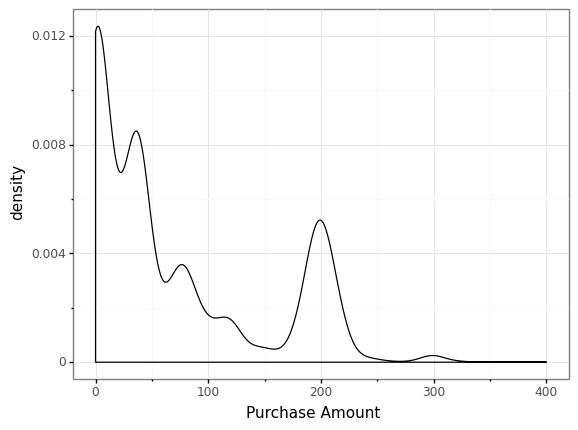

<ggplot: (8789073177869)>

In [ ]:
ggplot(subscribers, aes(x='purch_amt', color = 'limited_subscriber')) + geom_density() + theme_bw() + xlim(0,400) + labs(x = "Purchase Amount")

In [ ]:
purch_reasonable = subscribers['purch_amt'] < 500
subscribers = subscribers[purch_reasonable]

subscribers.describe()

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber
count,25403.000000,25403.000000,25403.000000,25403.000000,25402.000000,25403.000000,25403.000000,18575.000000,18575.000000,18575.000000,18575.000000,18575.000000,25403.000000,25403.000000
mean,22070.906507,69.003297,0.179073,0.101602,0.319502,0.392828,0.570877,38.377927,10.510417,2.984118,4.756985,0.484415,0.786049,0.213951
std,11476.043045,76.930194,0.383421,0.302130,0.466293,0.488389,0.494961,65.663702,44.752096,36.100549,14.485961,1.335730,0.410101,0.410101
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12501.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,23270.000000,35.970000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,32093.500000,119.000000,0.000000,0.000000,1.000000,1.000000,1.000000,45.000000,7.000000,1.000000,3.000000,1.000000,1.000000,0.000000
max,39998.000000,488.430000,1.000000,1.000000,1.000000,1.000000,1.000000,4370.000000,4365.000000,4348.000000,196.000000,44.000000,1.000000,1.000000


In [ ]:
free_trials = subscribers["free_trial_user"] == 1

free_trial_users = subscribers.loc[free_trials]
free_trial_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2581 entries, 8 to 40054
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       2581 non-null   int64         
 1   language                 2581 non-null   object        
 2   subscription_type        2581 non-null   object        
 3   subscription_event_type  2581 non-null   object        
 4   purch_store              2581 non-null   object        
 5   purch_amt                2581 non-null   float64       
 6   currency                 2581 non-null   object        
 7   subscription_start       2581 non-null   datetime64[ns]
 8   subscription_exp         2581 non-null   datetime64[ns]
 9   demo_user                2581 non-null   int64         
 10  free_trial_user          2581 non-null   int64         
 11  free_trial_start         2581 non-null   datetime64[ns]
 12  free_trial_exp           2581 non

In [ ]:
free_trial_users.head()

,id,language,subscription_type,subscription_event_type,purch_store,purch_amt,currency,subscription_start,subscription_exp,demo_user,free_trial_user,free_trial_start,free_trial_exp,auto_renew,country,user_type,platform_used,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber
8,9,DEU,Limited,INITIAL_PURCHASE,Web,43.16,USD,2020-03-03,2020-06-08,0,1,2020-03-03,2020-03-06,1.0,Europe,Consumer,Web,0,1,52.0,11.0,0.0,5.0,0.0,1,0
11,12,ESP,Limited,INITIAL_PURCHASE,Web,35.97,USD,2019-10-17,2020-01-21,0,1,2019-10-17,2019-10-20,0.0,US/Canada,Consumer,Web,1,1,94.0,0.0,0.0,0.0,0.0,1,0
16,17,ALL,Lifetime,INITIAL_PURCHASE,Web,199.00,USD,2020-03-25,2099-01-01,0,1,2020-03-20,2020-03-23,0.0,US/Canada,Consumer,Web,1,1,8.0,6.0,3.0,2.0,1.0,0,1
34,35,EBR,Limited,INITIAL_PURCHASE,Web,35.97,USD,2019-07-19,2019-10-22,0,1,2019-07-19,2019-07-22,1.0,Europe,Consumer,Web,0,1,NaN,NaN,NaN,NaN,NaN,1,0
41,42,ESP,Limited,INITIAL_PURCHASE,Web,38.89,USD,2020-01-27,2020-04-30,0,1,2020-01-27,2020-01-30,0.0,US/Canada,Consumer,Web,1,1,19.0,11.0,4.0,7.0,2.0,1,0


In [ ]:
no_free_trials = subscribers["free_trial_user"] == 0

no_free_trial_users = subscribers.loc[no_free_trials]

no_free_trial_users = no_free_trial_users.drop(["free_trial_user", "free_trial_start", "free_trial_exp"],1)
no_free_trial_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22822 entries, 1 to 40099
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       22822 non-null  int64         
 1   language                 22822 non-null  object        
 2   subscription_type        22822 non-null  object        
 3   subscription_event_type  22822 non-null  object        
 4   purch_store              22822 non-null  object        
 5   purch_amt                22822 non-null  float64       
 6   currency                 22822 non-null  object        
 7   subscription_start       22822 non-null  datetime64[ns]
 8   subscription_exp         22822 non-null  datetime64[ns]
 9   demo_user                22822 non-null  int64         
 10  auto_renew               22822 non-null  float64       
 11  country                  22822 non-null  object        
 12  user_type                22822 n

In [ ]:
subscribers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25403 entries, 1 to 40099
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       25403 non-null  int64         
 1   language                 25403 non-null  object        
 2   subscription_type        25403 non-null  object        
 3   subscription_event_type  25403 non-null  object        
 4   purch_store              25403 non-null  object        
 5   purch_amt                25403 non-null  float64       
 6   currency                 25403 non-null  object        
 7   subscription_start       25403 non-null  datetime64[ns]
 8   subscription_exp         25403 non-null  datetime64[ns]
 9   demo_user                25403 non-null  int64         
 10  free_trial_user          25403 non-null  int64         
 11  free_trial_start         2581 non-null   datetime64[ns]
 12  free_trial_exp           2581 no

In [ ]:
subscribers = subscribers.dropna(subset=['currency', 'auto_renew'])
subscribers['currency'] = fct_lump(subscribers['currency'], n = 8)

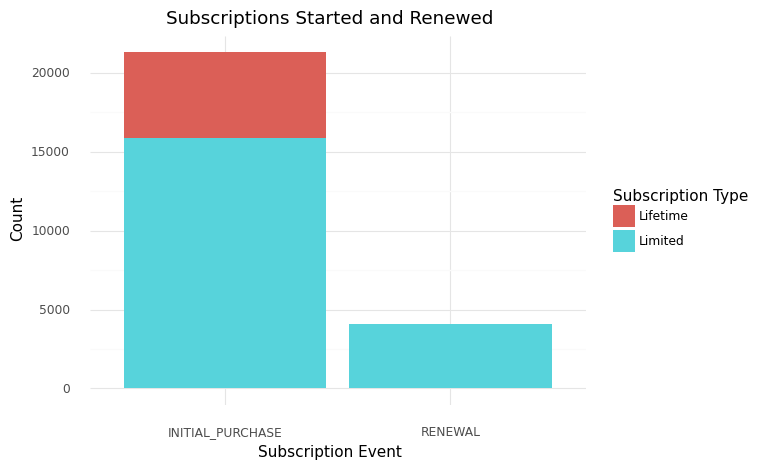

<ggplot: (8789073160045)>

In [ ]:
#Subscription type and renewal/start
(ggplot(subscribers, aes(x = "subscription_event_type", fill = "subscription_type")) + geom_bar() + theme_minimal() + labs(title = "Subscriptions Started and Renewed", fill = "Subscription Type", y = "Count", x = 'Subscription Event'))

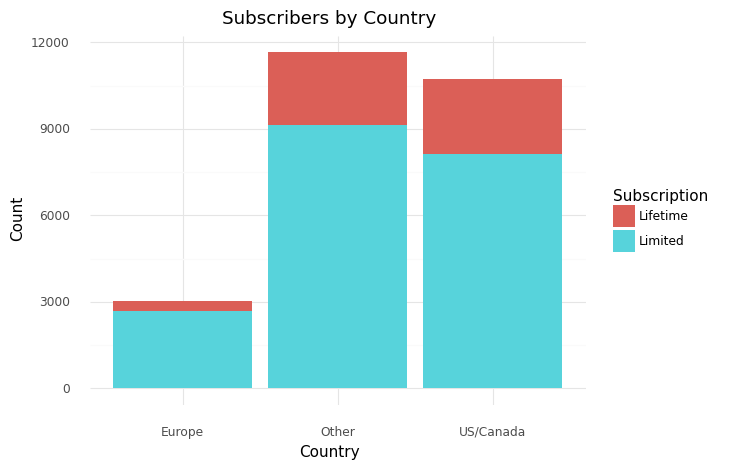

<ggplot: (8789071522657)>

In [ ]:
#Subscription type and country
(ggplot(subscribers, aes(x = "country", fill = "subscription_type")) + geom_bar() + theme_minimal() + labs(title = "Subscribers by Country", fill = "Subscription", y = "Count", x = "Country"))

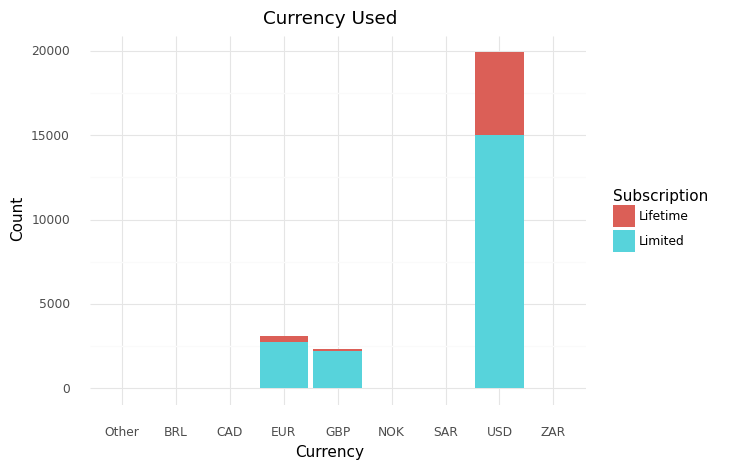

<ggplot: (8789071528161)>

In [ ]:
(ggplot(subscribers, aes(x = "currency", fill = "subscription_type")) + geom_bar() + theme_minimal() + labs(title = "Currency Used", fill = "Subscription", y = "Count", x = "Currency"))

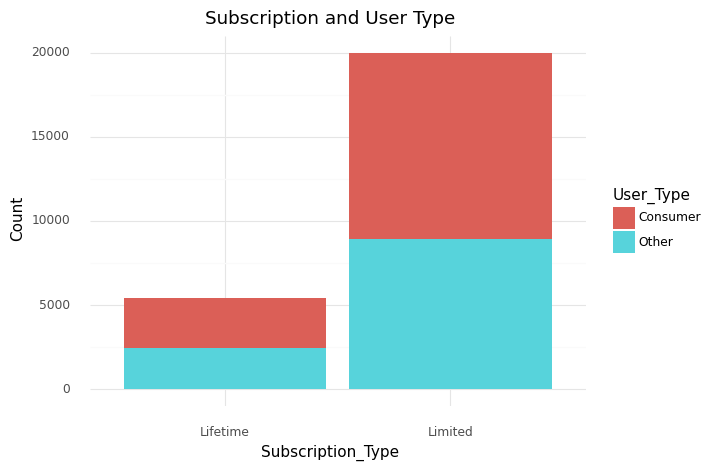

<ggplot: (8789071546053)>

In [ ]:
#Users and subscription type

(ggplot(subscribers, aes(x = "subscription_type", fill = "user_type")) + geom_bar() + theme_minimal() + 
 labs(title = "Subscription and User Type", fill = "User_Type", y = "Count", x = "Subscription_Type"))

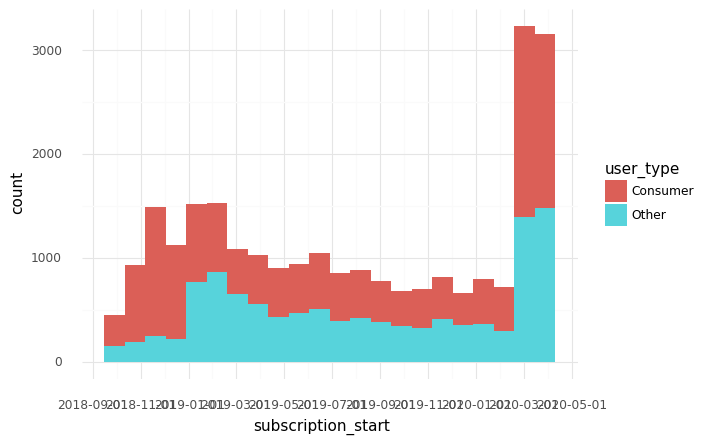

<ggplot: (8789062569693)>

In [ ]:
#Consumer type over time

(ggplot(subscribers, aes(x = "subscription_start", fill = "user_type")) + geom_histogram() + theme_minimal())

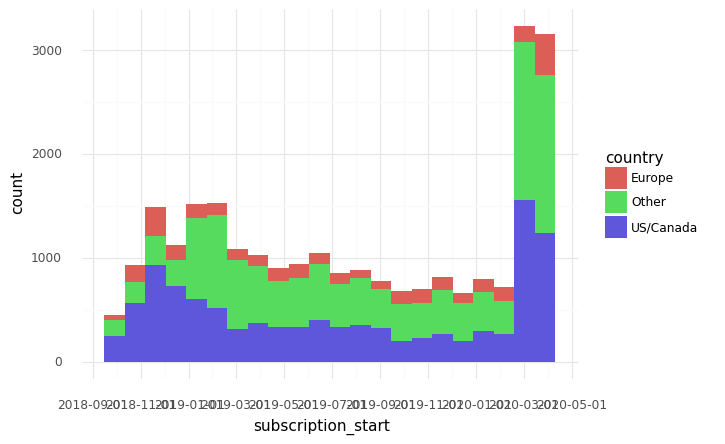

<ggplot: (8789062512933)>

In [ ]:
#Country over time
(ggplot(subscribers, aes(x = "subscription_start", fill = "country")) + geom_histogram() + theme_minimal())

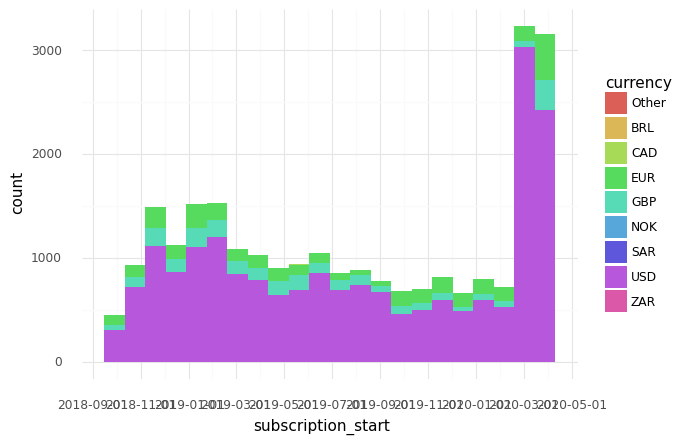

<ggplot: (8789062515341)>

In [ ]:
#Currency over time, not very useful

(ggplot(subscribers, aes(x = "subscription_start", fill = "currency")) + geom_histogram() + theme_minimal())

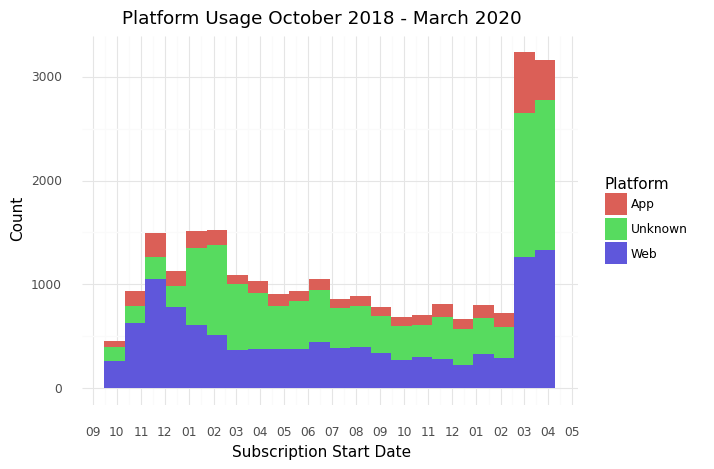

<ggplot: (8789062368053)>

In [ ]:
#Platform used over time
(ggplot(subscribers, aes(x = "subscription_start", fill = "platform_used")) + geom_histogram() + theme_minimal() + 
 labs(title = "Platform Usage October 2018 - March 2020", y = "Count", fill = "Platform", x = "Subscription Start Date")+
 scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%m')))

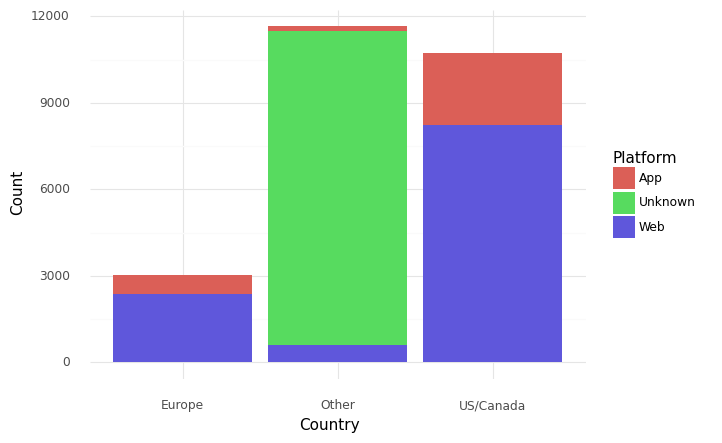

<ggplot: (8789062406369)>

In [ ]:
#Country of user and platform used for Rosetta Stone
(ggplot(subscribers, aes(x = "country", fill = "platform_used")) + geom_bar() + theme_minimal() + labs(fill = "Platform", y = "Count", x = "Country"))

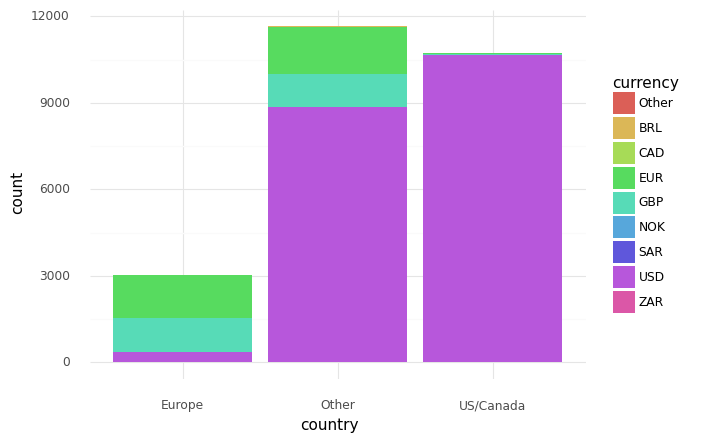

<ggplot: (8789062338285)>

In [ ]:
#Checking country of subscriber compared to currency used to subscribe

(ggplot(subscribers, aes(x = "country", fill = "currency")) + geom_bar() + theme_minimal())

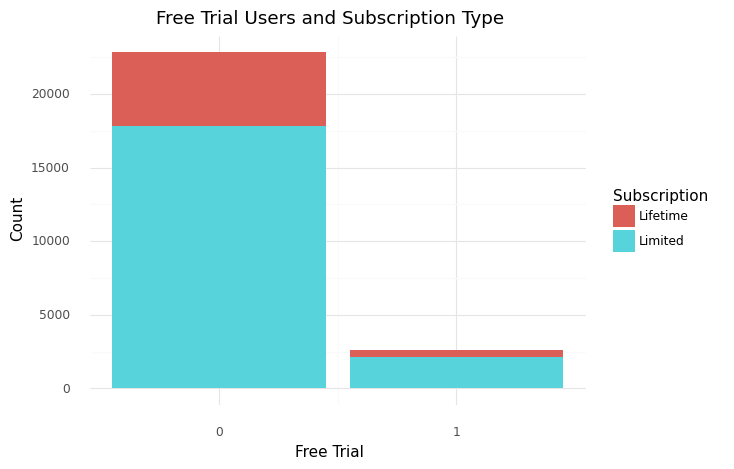

<ggplot: (8789062331617)>

In [ ]:
#Looking at free trial users and what type of subscription

(ggplot(subscribers, aes(x = ('free_trial_user'), fill = "subscription_type")) + geom_bar() + theme_minimal() + scale_x_continuous(breaks = [0,1]) + 
 labs(title = "Free Trial Users and Subscription Type", fill = "Subscription", y = "Count", x = "Free Trial"))

In [ ]:
subscribers.head()

,id,language,subscription_type,subscription_event_type,purch_store,purch_amt,currency,subscription_start,subscription_exp,demo_user,free_trial_user,free_trial_start,free_trial_exp,auto_renew,country,user_type,platform_used,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.00,USD,2019-11-28,2020-02-28,0,0,NaT,NaT,0.0,Other,Consumer,Web,0,1,4.0,3.0,0.0,1.0,0.0,1,0
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.00,USD,2018-12-31,2019-12-31,0,0,NaT,NaT,0.0,US/Canada,Consumer,Web,1,1,1.0,0.0,0.0,0.0,0.0,1,0
5,6,ESP,Limited,INITIAL_PURCHASE,Web,38.34,USD,2019-08-23,2019-11-23,1,0,NaT,NaT,0.0,US/Canada,Consumer,App,1,1,162.0,1.0,0.0,1.0,0.0,1,0
6,7,ESP,Limited,RENEWAL,Web,79.00,USD,2019-07-21,2019-11-11,1,0,NaT,NaT,0.0,Other,Consumer,App,1,1,2.0,0.0,0.0,0.0,0.0,1,0
7,8,DEU,Limited,INITIAL_PURCHASE,Web,38.40,USD,2020-03-07,2020-06-07,1,0,NaT,NaT,1.0,US/Canada,Consumer,App,1,1,25.0,17.0,4.0,7.0,2.0,1,0


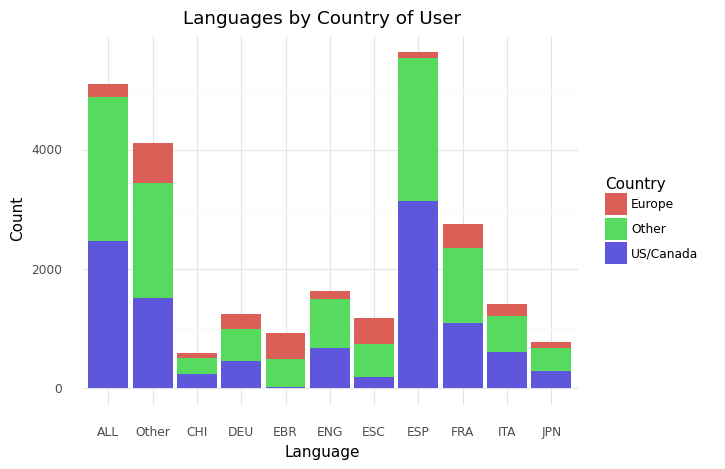

<ggplot: (8789062141769)>

In [ ]:
#Getting top 10 languages studied

subscribers['language_10'] = fct_lump(subscribers['language'], n = 10)

(ggplot(subscribers, aes(x = ('language_10'), fill = "country")) + geom_bar() + theme_minimal() + labs(title = "Languages by Country of User", fill = "Country", y = "Count", x = "Language"))

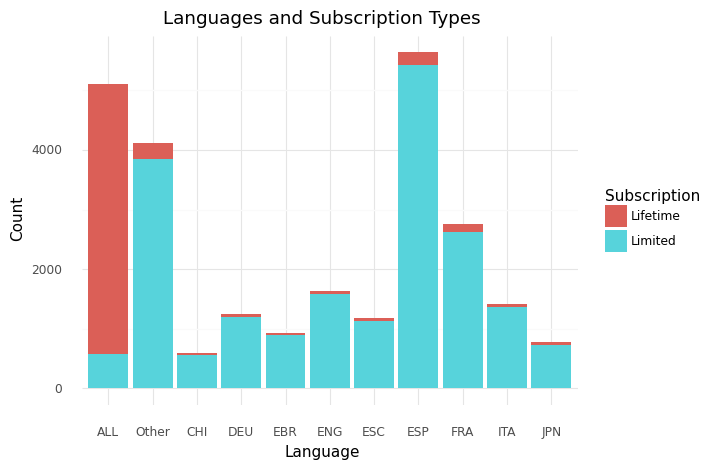

<ggplot: (8789062085837)>

In [ ]:
(ggplot(subscribers, aes(x = ('language_10'), fill = "subscription_type")) + geom_bar() + theme_minimal() + labs(title = "Languages and Subscription Types", fill = "Subscription", y = "Count", x = "Language"))

In [ ]:
#Proportion of unique emails opened to emails sent to measure engagement
email_sent_open_ratio = subscribers.unique_emails_opened/subscribers.emails_sent
subscribers['email_sent_open_ratio'] = email_sent_open_ratio
subscribers['subscription_len'] = (subscribers.subscription_exp - subscribers.subscription_start)

days = []

for x in subscribers.subscription_len:
  x = str(x)
  x_short = x.strip('days 00:00:00')
  days.append(int(x_short))

#days

subscribers['subscription_len'] = days

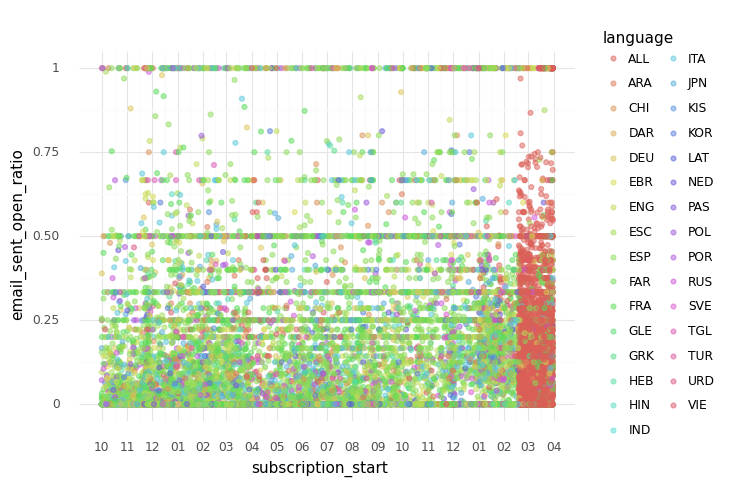

<ggplot: (8789062222693)>

In [ ]:
(ggplot(subscribers, aes(y = "email_sent_open_ratio", x = "subscription_start", color = "language")) + 
 geom_point(alpha = 0.5) + theme_minimal() + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%m')))

In [ ]:
subscribers.head()

,id,language,subscription_type,subscription_event_type,purch_store,purch_amt,currency,subscription_start,subscription_exp,demo_user,free_trial_user,free_trial_start,free_trial_exp,auto_renew,country,user_type,platform_used,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,language_10,email_sent_open_ratio,subscription_len
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.00,USD,2019-11-28,2020-02-28,0,0,NaT,NaT,0.0,Other,Consumer,Web,0,1,4.0,3.0,0.0,1.0,0.0,1,0,EBR,0.250000,92
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.00,USD,2018-12-31,2019-12-31,0,0,NaT,NaT,0.0,US/Canada,Consumer,Web,1,1,1.0,0.0,0.0,0.0,0.0,1,0,ESP,0.000000,365
5,6,ESP,Limited,INITIAL_PURCHASE,Web,38.34,USD,2019-08-23,2019-11-23,1,0,NaT,NaT,0.0,US/Canada,Consumer,App,1,1,162.0,1.0,0.0,1.0,0.0,1,0,ESP,0.006173,92
6,7,ESP,Limited,RENEWAL,Web,79.00,USD,2019-07-21,2019-11-11,1,0,NaT,NaT,0.0,Other,Consumer,App,1,1,2.0,0.0,0.0,0.0,0.0,1,0,ESP,0.000000,113
7,8,DEU,Limited,INITIAL_PURCHASE,Web,38.40,USD,2020-03-07,2020-06-07,1,0,NaT,NaT,1.0,US/Canada,Consumer,App,1,1,25.0,17.0,4.0,7.0,2.0,1,0,DEU,0.280000,92


In [ ]:
#subscribers.info()

Get the dummies for our categorical variables

In [ ]:
languages = pd.get_dummies(subscribers["language"])
subsc_events = pd.get_dummies(subscribers["subscription_event_type"])
subsc_type= pd.get_dummies(subscribers["subscription_type"])
store_purchs = pd.get_dummies(subscribers['purch_store'])
store_purchs = store_purchs.rename(columns={"Web":"webstore", "App":"appstore"})

currencies = pd.get_dummies(subscribers['currency'])


countries = pd.get_dummies(subscribers["country"])
countries['other_country'] = countries.Other
countries = countries.drop("Other",1)
user_types = pd.get_dummies(subscribers["user_type"])
user_types['other_consumer'] = user_types.Other
user_types = user_types.drop("Other",1)

platforms = pd.get_dummies(subscribers["platform_used"])

store_purchs.head()



,appstore,webstore
1,0,1
2,0,1
5,0,1
6,0,1
7,0,1


In [ ]:
subscribers_full = pd.concat([subscribers,languages,subsc_type, subsc_events, store_purchs, currencies, countries, user_types, platforms], axis = 1)

subscribers_full = subscribers_full.rename(columns={"Other":"other_currency"})

Here's the full dataframe so far:

In [ ]:
#subscribers_full.info()

In [ ]:
us_dollars = subscribers_full['currency'] == "USD"
subscribers_USD = subscribers_full[us_dollars]
#subscribers_USD.info()

In [ ]:
subscribers_unlimited = subscribers_USD["Lifetime"] == 1
subscribers_USD_unlimited = subscribers_USD[subscribers_unlimited]
subscribers_USD_unlimited.describe()

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,GLE,GRK,HEB,HIN,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web
count,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4893.0,4893.0,4516.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.0,4893.000000,4893.0,4893.000000,4893.000000,4893.00000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.0,4893.000000,4893.000000,4893.0,4893.000000,4893.0,4893.000000,4893.0,4893.0,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.0,4893.000000,4893.0,4893.0,4893.0,4893.0,4893.000000,4893.000000,4893.0,4893.0,4893.0,4893.0,4893.0,4893.0,4893.0,4893.0,4893.0,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000
mean,21568.523401,191.146634,0.210914,0.084406,0.000817,0.489679,0.572859,50.413862,18.695306,5.181355,8.686891,1.014172,0.0,1.0,0.156033,26328.259350,0.869405,0.002452,0.005927,0.0,0.005722,0.0,0.007153,0.003679,0.04251,0.000613,0.015941,0.000613,0.000613,0.001226,0.000817,0.0,0.006131,0.004905,0.0,0.002248,0.0,0.000817,0.0,0.0,0.002657,0.002452,0.004905,0.017576,0.001226,0.0,0.000409,1.0,0.0,1.0,0.0,0.000204,0.999796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.011445,0.532802,0.455753,0.561823,0.438177,0.177192,0.426936,0.395872
std,11396.550415,49.361744,0.407999,0.278025,0.028583,0.499945,0.494714,74.185717,47.638884,25.142387,20.272241,2.030613,0.0,0.0,0.190634,7747.043845,0.336991,0.049467,0.076765,0.0,0.075438,0.0,0.084281,0.060547,0.20177,0.024756,0.125261,0.024756,0.024756,0.035000,0.028583,0.0,0.078070,0.069871,0.0,0.047366,0.0,0.028583,0.0,0.0,0.051481,0.049467,0.069871,0.131418,0.035000,0.0,0.020215,0.0,0.0,0.0,0.0,0.014296,0.014296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106378,0.498974,0.498089,0.496214,0.496214,0.381870,0.494683,0.489087
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,29.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12018.000000,189.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,28772.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.0,1.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22222.000000,199.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,3.000000,0.000000,2.000000,0.000000,0.0,1.0,0.111111,28788.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.0,1.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,31603.000000,207.960000,0.000000,0.000000,0.000000,1.000000,1.000000,83.000000,16.000000

In [ ]:
subscribers_lim = subscribers_USD.limited_subscriber == 1
subscribers_limited_USD = subscribers_USD[subscribers_lim]
subscribers_limited_USD.describe()

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,GLE,GRK,HEB,HIN,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web
count,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,11486.000000,11486.000000,11486.000000,11486.000000,11486.000000,15022.0,15022.0,11486.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.0,15022.0,15022.000000,15022.000000,15022.000000,15022.000000,15022.0,15022.0,15022.0,15022.0,15022.0,15022.0,15022.0,15022.0,15022.0,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000
mean,22225.737984,37.025989,0.173146,0.108108,0.389362,0.436626,0.594062,37.409977,6.903274,1.358262,3.696326,0.275640,1.0,0.0,0.130345,237.232060,0.033418,0.017707,0.027759,0.001797,0.054587,0.005459,0.090268,0.023166,0.352616,0.005792,0.126681,0.002862,0.010851,0.011516,0.005725,0.001265,0.067102,0.035748,0.003395,0.016709,0.008854,0.005592,0.000133,0.006257,0.018107,0.022567,0.009453,0.023499,0.004061,0.001531,0.005525,0.0,1.0,0.783451,0.216549,0.005459,0.994541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.020703,0.537279,0.442018,0.571695,0.428305,0.121222,0.405871,0.472906
std,11339.111383,43.183213,0.378386,0.310527,0.487622,0.495984,0.491089,52.426004,21.467298,9.159111,12.634409,0.851607,0.0,0.0,0.200704,180.098749,0.179731,0.131890,0.164288,0.042359,0.227179,0.073683,0.286574,0.150436,0.477800,0.075884,0.332626,0.053427,0.103604,0.106699,0.075449,0.035543,0.250206,0.185666,0.058170,0.128182,0.093680,0.074571,0.011538,0.078859,0.133342,0.148523,0.096768,0.151487,0.063596,0.039100,0.074129,0.0,0.0,0.411906,0.411906,0.073683,0.073683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142393,0.498625,0.496643,0.494850,0.494850,0.326396,0.491076,0.499282
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12937.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,23455.500000,35.970000,0.000000,0.000000,0.000000,0.000000,1.000000,14.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.026455,183.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

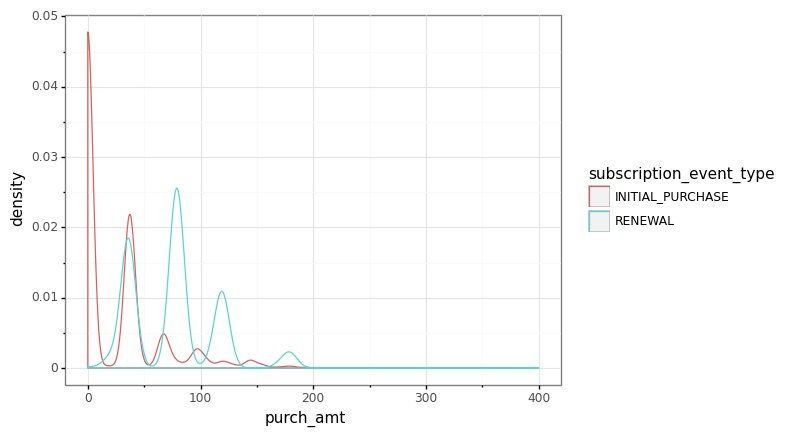

<ggplot: (8789062371305)>

In [ ]:
ggplot(subscribers_limited_USD, aes(x='purch_amt', color = 'subscription_event_type')) + geom_density() + theme_bw() + xlim(0,400)

In [ ]:
#Here we need to figure out what the renewals are for

subscribers_limited_USD['monthly_renewals'] = subscribers_limited_USD.subscription_len/92

subscribers_3_mo = subscribers_limited_USD.monthly_renewals == 1
subscribers_3_mo = subscribers_limited_USD[subscribers_3_mo]
nonzero = subscribers_3_mo['purch_amt'] != 0
subscribers_3_mo = subscribers_3_mo[nonzero]
subscribers_3_mo.describe()

#If the days of subscription are multiple of 365, that's a 12 month subscriber

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,GLE,GRK,HEB,HIN,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web,monthly_renewals
count,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,934.000000,934.000000,934.000000,934.000000,934.000000,1239.0,1239.0,934.000000,1239.0,1239.000000,1239.000000,1239.000000,1239.0,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.0,1239.000000,1239.000000,1239.0,1239.000000,1239.0,1239.000000,1239.0,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.0,1239.000000,1239.0,1239.0,1239.000000,1239.000000,1239.000000,1239.000000,1239.0,1239.0,1239.0,1239.0,1239.0,1239.0,1239.0,1239.0,1239.0,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.0
mean,23969.960452,38.675270,0.218725,0.020985,0.403551,0.268765,0.383374,34.882227,5.422912,1.078158,3.099572,0.274090,1.0,0.0,0.104060,92.0,0.000807,0.022599,0.027441,0.0,0.050847,0.008071,0.097659,0.028249,0.394673,0.003228,0.119451,0.002421,0.014528,0.012107,0.009685,0.0,0.055690,0.041162,0.0,0.012914,0.0,0.008878,0.0,0.008878,0.017756,0.025827,0.008878,0.013721,0.003228,0.0,0.011299,0.0,1.0,0.995964,0.004036,0.002421,0.997579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.016949,0.335755,0.647296,0.379338,0.620662,0.160613,0.616626,0.222760,1.0
std,11212.417510,10.897654,0.413548,0.143391,0.490808,0.443497,0.486404,46.739008,14.807733,6.712540,9.039614,0.774619,0.0,0.0,0.167048,0.0,0.028410,0.148681,0.163432,0.0,0.219775,0.089512,0.296973,0.165749,0.488978,0.056750,0.324450,0.049167,0.119701,0.109406,0.097975,0.0,0.229415,0.198746,0.0,0.112948,0.0,0.093842,0.0,0.093842,0.132118,0.158684,0.093842,0.116376,0.056750,0.0,0.105739,0.0,0.0,0.063423,0.063423,0.049167,0.049167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129133,0.472444,0.478004,0.485418,0.485418,0.367322,0.486404,0.416267,0.0
min,2.000000,13.610000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,92.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,15164.000000,35.970000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,92.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,25982.000000,35.970000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.017964,92.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.0000

In [ ]:
subscribers_limited_USD.head()

,id,language,subscription_type,subscription_event_type,purch_store,purch_amt,currency,subscription_start,subscription_exp,demo_user,free_trial_user,free_trial_start,free_trial_exp,auto_renew,country,user_type,platform_used,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,language_10,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,...,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web,monthly_renewals
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.00,USD,2019-11-28,2020-02-28,0,0,NaT,NaT,0.0,Other,Consumer,Web,0,1,4.0,3.0,0.0,1.0,0.0,1,0,EBR,0.250000,92,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1.000000
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.00,USD,2018-12-31,2019-12-31,0,0,NaT,NaT,0.0,US/Canada,Consumer,Web,1,1,1.0,0.0,0.0,0.0,0.0,1,0,ESP,0.000000,365,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,3.967391
5,6,ESP,Limited,INITIAL_PURCHASE,Web,38.34,USD,2019-08-23,2019-11-23,1,0,NaT,NaT,0.0,US/Canada,Consumer,App,1,1,162.0,1.0,0.0,1.0,0.0,1,0,ESP,0.006173,92,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1.000000
6,7,ESP,Limited,RENEWAL,Web,79.00,USD,2019-07-21,2019-11-11,1,0,NaT,NaT,0.0,Other,Consumer,App,1,1,2.0,0.0,0.0,0.0,0.0,1,0,ESP,0.000000,113,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1.228261
7,8,DEU,Limited,INITIAL_PURCHASE,Web,38.40,USD,2020-03-07,2020-06-07,1,0,NaT,NaT,1.0,US/Canada,Consumer,App,1,1,25.0,17.0,4.0,7.0,2.0,1,0,DEU,0.280000,92,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1.000000


In [ ]:
year_limited = []
for length in subscribers_limited_USD.subscription_len:
  if length % 365 == 0:
    yearly = 1
  elif length % 366 == 0:
    yearly = 1
  else:
    yearly = 0
  year_limited.append(yearly)

print(sum(year_limited))
subscribers_limited_USD['year_subscriber'] = year_limited

subscribers_limited_USD.head()



3202


,id,language,subscription_type,subscription_event_type,purch_store,purch_amt,currency,subscription_start,subscription_exp,demo_user,free_trial_user,free_trial_start,free_trial_exp,auto_renew,country,user_type,platform_used,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,language_10,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,...,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web,monthly_renewals,year_subscriber
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.00,USD,2019-11-28,2020-02-28,0,0,NaT,NaT,0.0,Other,Consumer,Web,0,1,4.0,3.0,0.0,1.0,0.0,1,0,EBR,0.250000,92,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1.000000,0
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.00,USD,2018-12-31,2019-12-31,0,0,NaT,NaT,0.0,US/Canada,Consumer,Web,1,1,1.0,0.0,0.0,0.0,0.0,1,0,ESP,0.000000,365,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,3.967391,1
5,6,ESP,Limited,INITIAL_PURCHASE,Web,38.34,USD,2019-08-23,2019-11-23,1,0,NaT,NaT,0.0,US/Canada,Consumer,App,1,1,162.0,1.0,0.0,1.0,0.0,1,0,ESP,0.006173,92,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1.000000,0
6,7,ESP,Limited,RENEWAL,Web,79.00,USD,2019-07-21,2019-11-11,1,0,NaT,NaT,0.0,Other,Consumer,App,1,1,2.0,0.0,0.0,0.0,0.0,1,0,ESP,0.000000,113,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1.228261,0
7,8,DEU,Limited,INITIAL_PURCHASE,Web,38.40,USD,2020-03-07,2020-06-07,1,0,NaT,NaT,1.0,US/Canada,Consumer,App,1,1,25.0,17.0,4.0,7.0,2.0,1,0,DEU,0.280000,92,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1.000000,0


In [ ]:
monthly_limited = []
for length in subscribers_limited_USD.subscription_len:
  if length % 92 == 0:
    monthly = 1
  else:
    monthly = 0
  monthly_limited.append(monthly)

print(sum(monthly_limited))
subscribers_limited_USD['quarterly_subscriber'] = monthly_limited

3016


In [ ]:
quarter_or_year = []
for length in subscribers_limited_USD.subscription_len:
  if length % 92 == 0:
    subs = "quarter"
  elif length % 365 == 0:
    subs = "yearly"
  elif length % 366 == 0:
    subs = "yearly"
  else:
    subs = "other"
  quarter_or_year.append(subs)

subscribers_limited_USD['quarter_or_year'] = quarter_or_year
  

In [ ]:
subscribers_limited_USD['yearly_renewals'] = subscribers_limited_USD.subscription_len/365

In [ ]:
subscribers_limited_USD.describe()

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,GLE,GRK,HEB,HIN,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web,monthly_renewals,year_subscriber,quarterly_subscriber,yearly_renewals
count,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,11486.000000,11486.000000,11486.000000,11486.000000,11486.000000,15022.0,15022.0,11486.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.0,15022.0,15022.000000,15022.000000,15022.000000,15022.000000,15022.0,15022.0,15022.0,15022.0,15022.0,15022.0,15022.0,15022.0,15022.0,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000,15022.000000
mean,22225.737984,37.025989,0.173146,0.108108,0.389362,0.436626,0.594062,37.409977,6.903274,1.358262,3.696326,0.275640,1.0,0.0,0.130345,237.232060,0.033418,0.017707,0.027759,0.001797,0.054587,0.005459,0.090268,0.023166,0.352616,0.005792,0.126681,0.002862,0.010851,0.011516,0.005725,0.001265,0.067102,0.035748,0.003395,0.016709,0.008854,0.005592,0.000133,0.006257,0.018107,0.022567,0.009453,0.023499,0.004061,0.001531,0.005525,0.0,1.0,0.783451,0.216549,0.005459,0.994541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.020703,0.537279,0.442018,0.571695,0.428305,0.121222,0.405871,0.472906,2.578609,0.213154,0.200772,0.649951
std,11339.111383,43.183213,0.378386,0.310527,0.487622,0.495984,0.491089,52.426004,21.467298,9.159111,12.634409,0.851607,0.0,0.0,0.200704,180.098749,0.179731,0.131890,0.164288,0.042359,0.227179,0.073683,0.286574,0.150436,0.477800,0.075884,0.332626,0.053427,0.103604,0.106699,0.075449,0.035543,0.250206,0.185666,0.058170,0.128182,0.093680,0.074571,0.011538,0.078859,0.133342,0.148523,0.096768,0.151487,0.063596,0.039100,0.074129,0.0,0.0,0.411906,0.411906,0.073683,0.073683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142393,0.498625,0.496643,0.494850,0.494850,0.326396,0.491076,0.499282,1.957595,0.409549,0.400591,0.493421
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010870,0.000000,0.000000,0.002740
25%,12937.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.252055
50%,23455.500000,35.970000,0.000000,0.0000

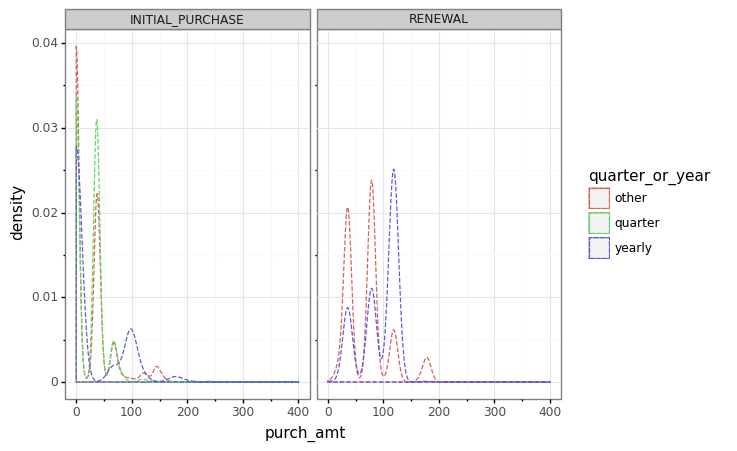

<ggplot: (8789071539573)>

In [ ]:
ggplot(subscribers_limited_USD, aes(x='purch_amt', color = 'quarter_or_year')) + geom_density(linetype = "dashed", alpha = 0.5) + theme_bw() + xlim(0,400) + facet_wrap("~subscription_event_type")

In [ ]:
subscribers_limited_quarterly = ((subscribers_limited_USD['quarterly_subscriber'] == 1))
subscribers__limited_quarterly = subscribers_limited_USD[subscribers_limited_quarterly]
subscribers__limited_quarterly.describe()

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,GLE,GRK,HEB,HIN,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web,monthly_renewals,year_subscriber,quarterly_subscriber,yearly_renewals
count,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,2144.000000,2144.000000,2144.000000,2144.000000,2144.000000,3016.0,3016.0,2144.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.0,3016.000000,3016.0,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.0,3016.0,3016.000000,3016.000000,3016.000000,3016.000000,3016.0,3016.0,3016.0,3016.0,3016.0,3016.0,3016.0,3016.0,3016.0,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.0,3016.0,3016.000000
mean,24352.011936,28.307036,0.201923,0.016247,0.268899,0.317639,0.450928,43.654384,5.639459,0.764459,3.503731,0.227146,1.0,0.0,0.084451,121.314324,0.000995,0.022546,0.026857,0.002321,0.050066,0.005968,0.097149,0.023541,0.383952,0.003316,0.134947,0.002321,0.013594,0.010942,0.009615,0.001326,0.068302,0.040119,0.001989,0.014257,0.0,0.007294,0.0,0.006631,0.019562,0.023210,0.005968,0.010942,0.004310,0.000332,0.007626,0.0,1.0,0.910809,0.089191,0.001326,0.998674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.015584,0.404841,0.579576,0.442971,0.557029,0.127653,0.549072,0.323276,1.318634,0.0,1.0,0.332368
std,11012.169105,28.678872,0.401502,0.126444,0.443461,0.465636,0.497669,51.465798,20.000540,5.225215,12.609205,0.836738,0.0,0.0,0.156591,60.892178,0.031528,0.148477,0.161692,0.048128,0.218118,0.077036,0.296209,0.151640,0.486427,0.057496,0.341724,0.048128,0.115818,0.104046,0.097602,0.036400,0.252306,0.196272,0.044566,0.118569,0.0,0.085109,0.0,0.081176,0.138514,0.150593,0.077036,0.104046,0.065522,0.018209,0.087008,0.0,0.0,0.285066,0.285066,0.036400,0.036400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123878,0.490943,0.493709,0.496819,0.496819,0.333758,0.497669,0.467805,0.661872,0.0,0.0,0.166828
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,0.252055
25%,16002.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,0.252055
50%,26276.500000,35.970000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [ ]:
subscribers_initial_limited_quarterly = ((subscribers_limited_USD['quarterly_subscriber'] == 1) & (subscribers_limited_USD['subscription_event_type'] == "RENEWAL"))
subscribers_initial_limited_quarterly = subscribers_limited_USD[subscribers_initial_limited_quarterly]
subscribers_initial_limited_quarterly.describe()

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,GLE,GRK,HEB,HIN,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web,monthly_renewals,year_subscriber,quarterly_subscriber,yearly_renewals
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,220.000000,220.000000,220.000000,220.000000,220.000000,269.0,269.0,220.000000,269.00000,269.000000,269.000000,269.000000,269.0,269.000000,269.000000,269.000000,269.000000,269.000000,269.0,269.000000,269.0,269.000000,269.000000,269.000000,269.0,269.000000,269.000000,269.0,269.000000,269.0,269.000000,269.0,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.0,269.000000,269.0,269.0,269.0,269.0,269.0,269.0,269.0,269.0,269.0,269.0,269.0,269.0,269.0,269.0,269.0,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.00000,269.000000,269.0,269.0,269.000000
mean,22858.791822,76.577844,0.223048,0.033457,0.215613,0.334572,0.460967,44.027273,5.227273,0.659091,3.504545,0.245455,1.0,0.0,0.091516,210.67658,0.007435,0.022305,0.029740,0.0,0.059480,0.007435,0.052045,0.029740,0.375465,0.0,0.133829,0.0,0.007435,0.007435,0.014870,0.0,0.070632,0.052045,0.0,0.022305,0.0,0.011152,0.0,0.014870,0.026022,0.026022,0.003717,0.007435,0.007435,0.0,0.011152,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.014870,0.412639,0.572491,0.460967,0.539033,0.122677,0.539033,0.33829,2.289963,0.0,1.0,0.577196
std,11367.254084,17.399455,0.417066,0.180162,0.412014,0.472720,0.499403,48.465204,14.215985,3.417275,9.152437,1.115981,0.0,0.0,0.173832,73.99861,0.086065,0.147948,0.170185,0.0,0.236961,0.086065,0.222531,0.170185,0.485145,0.0,0.341103,0.0,0.086065,0.086065,0.121258,0.0,0.256687,0.222531,0.0,0.147948,0.0,0.105210,0.0,0.121258,0.159498,0.159498,0.060971,0.086065,0.086065,0.0,0.105210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.121258,0.493227,0.495639,0.499403,0.499403,0.328677,0.499403,0.47401,0.804333,0.0,0.0,0.202736
min,599.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,92.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.0,1.0,0.252055
25%,13159.000000,79.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,184.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,0.0,1.0,0.504110
50%,23859.000000,79.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,184.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,2.000000,0.0,1.0,0.504110
75%,

In [ ]:
subscribers_initial_limited_quarterly = ((subscribers_limited_USD['year_subscriber'] == 1) & (subscribers_limited_USD['subscription_event_type'] == "INITIAL_PURCHASE"))
subscribers_initial_limited_quarterly = subscribers_limited_USD[subscribers_initial_limited_quarterly]
subscribers_initial_limited_quarterly.describe()

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,GLE,GRK,HEB,HIN,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web,monthly_renewals,year_subscriber,quarterly_subscriber,yearly_renewals
count,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,2598.0,2598.0,1984.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.0,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.0,2598.000000,2598.000000,2598.00000,2598.000000,2598.000000,2598.000000,2598.0,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.0,2598.0,2598.0,2598.0,2598.00000,2598.00000,2598.0,2598.0,2598.0,2598.0,2598.0,2598.0,2598.0,2598.0,2598.0,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.0,2598.0,2598.000000
mean,21737.165897,27.123818,0.183603,0.033487,0.392610,0.486143,0.677059,49.219758,9.194556,1.611895,5.335685,0.348790,1.0,0.0,0.134635,365.981909,0.123172,0.013857,0.025019,0.0,0.046189,0.002309,0.082371,0.021170,0.324095,0.003464,0.114704,0.001540,0.008853,0.009623,0.004234,0.0,0.054657,0.020015,0.00077,0.013857,0.042725,0.006159,0.0,0.005004,0.014627,0.017321,0.010778,0.024249,0.002309,0.001155,0.005774,0.0,1.0,1.0,0.0,0.00077,0.99923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.022325,0.615858,0.361817,0.639338,0.360662,0.130100,0.322941,0.546959,3.978064,1.0,0.0,1.002690
std,11102.252919,47.833863,0.387234,0.179940,0.488425,0.499904,0.467690,63.994595,27.687279,11.468107,16.373669,1.038502,0.0,0.0,0.216973,16.081906,0.328697,0.116919,0.156214,0.0,0.209935,0.048011,0.274982,0.143979,0.468126,0.058767,0.318725,0.039216,0.093691,0.097641,0.064944,0.0,0.227354,0.140080,0.02774,0.116919,0.202276,0.078250,0.0,0.070574,0.120076,0.130490,0.103274,0.153852,0.048011,0.033968,0.075780,0.0,0.0,0.0,0.0,0.02774,0.02774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.147766,0.486485,0.480619,0.480285,0.480285,0.336478,0.467690,0.497886,0.174803,0.0,0.0,0.044060
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,365.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.967391,1.0,0.0,1.000000
25%,12547.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,365.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.00000,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.967391,1.0,0.0,1.000000
50%,22977.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,16.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.024390,365.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000

In [ ]:
subscribers_initial_limited_quarterly = ((subscribers_limited_USD['year_subscriber'] == 1) & (subscribers_limited_USD['subscription_event_type'] == "RENEWAL"))
subscribers_initial_limited_quarterly = subscribers_limited_USD[subscribers_initial_limited_quarterly]
subscribers_initial_limited_quarterly.describe()

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,GLE,GRK,HEB,HIN,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web,monthly_renewals,year_subscriber,quarterly_subscriber,yearly_renewals
count,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,575.000000,575.000000,575.000000,575.000000,575.000000,604.0,604.0,575.000000,604.000000,604.000000,604.000000,604.000000,604.0,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.0,604.000000,604.000000,604.000000,604.0,604.000000,604.000000,604.0,604.000000,604.0,604.000000,604.0,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.0,604.000000,604.0,604.0,604.0,604.0,604.000000,604.000000,604.0,604.0,604.0,604.0,604.0,604.0,604.0,604.0,604.0,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.0,604.0,604.000000
mean,23150.697020,92.861904,0.160596,0.009934,0.632450,0.339404,0.435430,15.610435,4.532174,0.965217,2.040000,0.179130,1.0,0.0,0.197429,366.359272,0.001656,0.016556,0.014901,0.0,0.066225,0.004967,0.072848,0.026490,0.397351,0.004967,0.142384,0.0,0.008278,0.016556,0.001656,0.0,0.081126,0.028146,0.0,0.016556,0.0,0.008278,0.0,0.006623,0.021523,0.026490,0.004967,0.011589,0.008278,0.0,0.011589,0.0,1.0,0.0,1.0,0.013245,0.986755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.008278,0.405629,0.586093,0.425497,0.574503,0.089404,0.564570,0.346026,3.982166,1.0,0.0,1.003724
std,11196.553998,32.862851,0.367462,0.099254,0.482537,0.473900,0.496224,30.493980,13.460690,5.443934,7.041945,0.414354,0.0,0.0,0.228185,14.908624,0.040689,0.127707,0.121256,0.0,0.248881,0.070359,0.260102,0.160721,0.489755,0.070359,0.349733,0.0,0.090682,0.127707,0.040689,0.0,0.273255,0.165526,0.0,0.127707,0.0,0.090682,0.0,0.081176,0.145241,0.160721,0.070359,0.107117,0.090682,0.0,0.107117,0.0,0.0,0.0,0.0,0.114417,0.114417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090682,0.491420,0.492941,0.494828,0.494828,0.285562,0.496224,0.476096,0.162050,0.0,0.0,0.040846
min,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,365.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.967391,1.0,0.0,1.000000
25%,13823.250000,79.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,366.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,1.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.978261,1.0,0.0,1.002740
50%,24497.500000,119.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000,2.000000,0.000000,1.000000,0.000000,1.0,0.0,0.142857,366.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,1.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0

MODEL

Currently Rosetta Stone offers 3 mo, 12 mo, and Lifetime subscriptions
Normally about $35, $144, $199

Currently about 35, 96, and 149 for Black Friday Deal

Consumer Lifetime Value of Quarterly: 36 + 79 * renewal, average renewals is 1.32

CLV Yearly: 0 + 119 * renewal, average of 1 renewal

CLV of Lifetime: $199

Takes 2.063 renewals to match the CLV of a Lifetime member

The highest CLV still comes from a Lifetime subscriber. 


In [ ]:
subscribers_full['lost_subscriber'] = subscribers_full.subscription_exp <= '03/31/2020'
subscribers_full.head()
lost = pd.get_dummies(subscribers_full["lost_subscriber"], prefix='lost')

subscribers_full = pd.concat([subscribers_full, lost], 1)
subscribers_full = subscribers_full.rename(columns={False : "retained", True : "lost"})


In [ ]:
subscribers_full.columns

Index(['id', 'language', 'subscription_type', 'subscription_event_type',
       'purch_store', 'purch_amt', 'currency', 'subscription_start',
       'subscription_exp', 'demo_user', 'free_trial_user', 'free_trial_start',
       'free_trial_exp', 'auto_renew', 'country', 'user_type', 'platform_used',
       'email_subscriber', 'push_notifs', 'emails_sent', 'emails_opened',
       'emails_clicked', 'unique_emails_opened', 'unique_click_count',
       'limited_subscriber', 'lifetime_subscriber', 'language_10',
       'email_sent_open_ratio', 'subscription_len', 'ALL', 'ARA', 'CHI', 'DAR',
       'DEU', 'EBR', 'ENG', 'ESC', 'ESP', 'FAR', 'FRA', 'GLE', 'GRK', 'HEB',
       'HIN', 'IND', 'ITA', 'JPN', 'KIS', 'KOR', 'LAT', 'NED', 'PAS', 'POL',
       'POR', 'RUS', 'SVE', 'TGL', 'TUR', 'URD', 'VIE', 'Lifetime', 'Limited',
       'INITIAL_PURCHASE', 'RENEWAL', 'appstore', 'webstore', 'other_currency',
       'BRL', 'CAD', 'EUR', 'GBP', 'NOK', 'SAR', 'USD', 'ZAR', 'Europe',
       'US/Canada', '

In [ ]:
lmod = LogisticRegression()
KF = RepeatedKFold(n_splits = 15, n_repeats= 3, random_state = 1)


preds = ['demo_user','free_trial_user','email_subscriber','push_notifs','emails_sent', 'emails_opened',
         'emails_clicked', 'unique_emails_opened', 'unique_click_count','ARA', 'CHI', 'DAR',
         'DEU', 'EBR', 'ENG', 'ESC', 'ESP', 'FAR', 'FRA', 'GLE', 'GRK', 'HEB',
         'HIN', 'IND', 'ITA', 'JPN', 'KIS', 'KOR', 'LAT', 'NED', 'PAS', 'POL',
         'POR', 'RUS', 'SVE', 'TGL', 'TUR', 'URD', 'VIE','INITIAL_PURCHASE','webstore',
         'BRL', 'CAD', 'EUR', 'GBP', 'NOK', 'SAR','USD', 'ZAR', 'Europe', 'US/Canada','Consumer',
         'App', 'Web']
vars = ['demo_user','free_trial_user','email_subscriber','push_notifs','emails_sent', 'emails_opened',
         'emails_clicked', 'unique_emails_opened', 'unique_click_count','ARA', 'CHI', 'DAR',
         'DEU', 'EBR', 'ENG', 'ESC', 'ESP', 'FAR', 'FRA', 'GLE', 'GRK', 'HEB',
         'HIN', 'IND', 'ITA', 'JPN', 'KIS', 'KOR', 'LAT', 'NED', 'PAS', 'POL',
         'POR', 'RUS', 'SVE', 'TGL', 'TUR', 'URD', 'VIE','INITIAL_PURCHASE','webstore',
         'BRL', 'CAD', 'EUR', 'GBP', 'NOK', 'SAR','USD', 'ZAR', 'Europe', 'US/Canada','Consumer',
         'App', 'Web', "lost_True"]

subscribers_vars = subscribers_full[vars]
subscribers_vars = subscribers_vars.dropna()

X = subscribers_vars[preds]
X = X.dropna()
y = subscribers_vars['lost_True']
y = y.dropna()
#z = StandardScaler()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

# I am not z-scoring the variables so we can discuss the numerical variables by increase in unit instead of standard deviation
#Since this will need to be interpretable for a general business audience


#X_train[preds] = z.fit_transform(X_train[preds])
#X_test[preds] = z.fit_transform(X_test[preds])

#X_train.info()

In [ ]:
lmod.fit(X_train,y_train)
lmod.predict_proba(X_test)


prob1=lmod.predict_proba(X_test)[:,1]
predicted=[1 if i > 0.6 else 0 for i in prob1]
accuracy_score(y_test, predicted)

0.7491251682368775

In [ ]:
lmod.coef_[0]

array([-0.01448761, -1.38032431, -0.6548715 ,  0.14031373,  0.02230673,
       -0.04315186, -0.00374422,  0.03526213, -0.7787719 ,  0.63519766,
        0.65775411,  0.06341512,  1.15541699,  0.3472772 ,  2.19622715,
        0.68994719,  2.27400584,  0.25418032,  1.8222477 ,  0.02194685,
        0.36061527,  0.29441658,  0.15335828,  0.04563904,  1.6760687 ,
        1.10198532,  0.07018831,  0.43274084,  0.0102549 ,  0.17274848,
       -0.00432811,  0.25195407,  0.47614524,  0.74755348, -0.05365878,
       -0.14457988,  0.1127022 ,  0.03418231,  0.25097464,  1.17683917,
       -1.14781434,  0.        , -0.00803313, -0.82393944, -0.25781511,
        0.        ,  0.        , -0.27049543,  0.        , -0.04601082,
       -0.09478214,  0.35308738, -0.3793134 ,  0.51962713])

In [ ]:
coefdf = pd.DataFrame({"Coefs": lmod.coef_[0], "names":preds})
coefdf = coefdf.append({"Coefs": lmod.intercept_[0], "names": "intercept"},ignore_index = True)

coefdf['Odds'] = np.exp(coefdf["Coefs"])
sorted = coefdf.sort_values(by = ['Odds'], ascending=False)
sorted.head(20)

,Coefs,names,Odds
16,2.274006,ESP,9.718253
14,2.196227,ENG,8.991028
18,1.822248,FRA,6.185747
24,1.676069,ITA,5.344504
39,1.176839,INITIAL_PURCHASE,3.244104
12,1.155417,DEU,3.175347
25,1.101985,JPN,3.010136
33,0.747553,RUS,2.111827
15,0.689947,ESC,1.993610
10,0.657754,CHI,1.930452


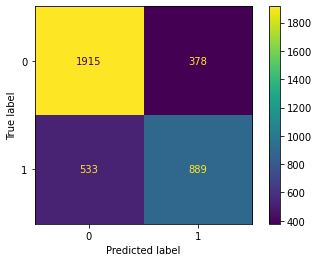

In [ ]:
plot_confusion_matrix(lmod, X_test,y_test)

In [ ]:
lr_lasso = LogisticRegression(penalty='l1', solver='liblinear')
lr_lasso.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
lr_lasso.predict_proba(X_test)

prob2=lr_lasso.predict_proba(X_test)[:,1]
predicted1=[1 if i > 0.5 else 0 for i in prob2]
accuracy_score(y_test, predicted1)

0.8358008075370121

In [ ]:
coefdf1 = pd.DataFrame({"Coefs": lr_lasso.coef_[0], "names":preds})
coefdf1 = coefdf.append({"Coefs": lr_lasso.intercept_[0], "names": "intercept"},ignore_index = True)

coefdf1['Odds'] = np.exp(coefdf1["Coefs"])
sorted1 = coefdf1.sort_values(by = ['Odds'], ascending=False)
sorted1.head(30)

,Coefs,names,Odds
16,2.274006,ESP,9.718253
14,2.196227,ENG,8.991028
18,1.822248,FRA,6.185747
24,1.676069,ITA,5.344504
39,1.176839,INITIAL_PURCHASE,3.244104
12,1.155417,DEU,3.175347
25,1.101985,JPN,3.010136
33,0.747553,RUS,2.111827
15,0.689947,ESC,1.993610
10,0.657754,CHI,1.930452


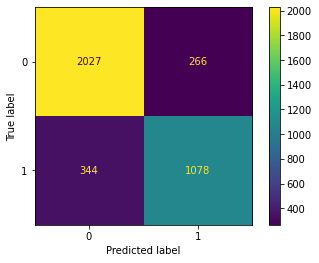

In [ ]:
plot_confusion_matrix(lr_lasso, X_test,y_test)

In [ ]:
#Code for predicting auto_renewal
lmod = LogisticRegression()
KF = RepeatedKFold(n_splits = 15, n_repeats= 3, random_state = 1)


preds = ['demo_user','free_trial_user','email_subscriber','push_notifs','emails_sent', 'emails_opened',
         'emails_clicked', 'unique_emails_opened', 'unique_click_count','ARA', 'CHI', 'DAR',
         'DEU', 'EBR', 'ENG', 'ESC', 'ESP', 'FAR', 'FRA', 'GLE', 'GRK', 'HEB',
         'HIN', 'IND', 'ITA', 'JPN', 'KIS', 'KOR', 'LAT', 'NED', 'PAS', 'POL',
         'POR', 'RUS', 'SVE', 'TGL', 'TUR', 'URD', 'VIE','INITIAL_PURCHASE','webstore',
         'BRL', 'CAD', 'EUR', 'GBP', 'NOK', 'SAR','USD', 'ZAR', 'Europe', 'US/Canada','Consumer',
         'App', 'Web', "lifetime_subscriber"]
vars = ['demo_user','free_trial_user','email_subscriber','push_notifs','emails_sent', 'emails_opened',
         'emails_clicked', 'unique_emails_opened', 'unique_click_count','ARA', 'CHI', 'DAR',
         'DEU', 'EBR', 'ENG', 'ESC', 'ESP', 'FAR', 'FRA', 'GLE', 'GRK', 'HEB',
         'HIN', 'IND', 'ITA', 'JPN', 'KIS', 'KOR', 'LAT', 'NED', 'PAS', 'POL',
         'POR', 'RUS', 'SVE', 'TGL', 'TUR', 'URD', 'VIE','INITIAL_PURCHASE','webstore',
         'BRL', 'CAD', 'EUR', 'GBP', 'NOK', 'SAR','USD', 'ZAR', 'Europe', 'US/Canada','Consumer',
         'App', 'Web', "lifetime_subscriber", "auto_renew"]

subscribers_vars = subscribers_full[vars]
subscribers_vars = subscribers_vars.dropna()

X = subscribers_vars[preds]
X = X.dropna()
y = subscribers_vars['auto_renew']
y = y.dropna()
#z = StandardScaler()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

lr_lasso1 = LogisticRegression(penalty='l1', solver='liblinear')
lr_lasso1.fit(X_train, y_train)
lr_lasso1.predict_proba(X_test)

prob3 =lr_lasso1.predict_proba(X_test)[:,1]
predicted2 = [1 if i > 0.5 else 0 for i in prob3]
accuracy_score(y_test, predicted2)

0.765814266487214

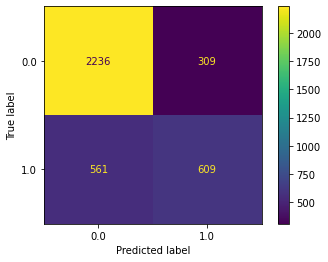

In [ ]:
plot_confusion_matrix(lr_lasso1, X_test,y_test)

In [ ]:
coefdf2 = pd.DataFrame({"Coefs": lr_lasso1.coef_[0], "names":preds})
coefdf2 = coefdf.append({"Coefs": lr_lasso1.intercept_[0], "names": "intercept"},ignore_index = True)

coefdf2['Odds'] = np.exp(coefdf2["Coefs"])
sorted2 = coefdf2.sort_values(by = ['Odds'], ascending=False)
sorted2.head(30)

,Coefs,names,Odds
55,3.397220,intercept,29.880923
16,2.274006,ESP,9.718253
14,2.196227,ENG,8.991028
18,1.822248,FRA,6.185747
24,1.676069,ITA,5.344504
39,1.176839,INITIAL_PURCHASE,3.244104
12,1.155417,DEU,3.175347
25,1.101985,JPN,3.010136
33,0.747553,RUS,2.111827
15,0.689947,ESC,1.993610


Bad clustering

In [ ]:
x_vars = (subscribers_vars)

z = StandardScaler()
xz_vars = z.fit_transform(x_vars)

hac = AgglomerativeClustering(affinity = "hamming",
                             linkage = "complete")
hac.fit(xz_vars)
membership = hac.labels_
silhouette_score(xz_vars,membership)

0.10975711858157325

the clustering here SUCKS


In [ ]:
#dendro = sch.dendrogram(sch.linkage(xz_vars, method='single'))

In [ ]:
subscribers_USD.head()

,id,language,subscription_type,subscription_event_type,purch_store,purch_amt,currency,subscription_start,subscription_exp,demo_user,free_trial_user,free_trial_start,free_trial_exp,auto_renew,country,user_type,platform_used,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,language_10,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,...,HIN,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.00,USD,2019-11-28,2020-02-28,0,0,NaT,NaT,0.0,Other,Consumer,Web,0,1,4.0,3.0,0.0,1.0,0.0,1,0,EBR,0.250000,92,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.00,USD,2018-12-31,2019-12-31,0,0,NaT,NaT,0.0,US/Canada,Consumer,Web,1,1,1.0,0.0,0.0,0.0,0.0,1,0,ESP,0.000000,365,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1
5,6,ESP,Limited,INITIAL_PURCHASE,Web,38.34,USD,2019-08-23,2019-11-23,1,0,NaT,NaT,0.0,US/Canada,Consumer,App,1,1,162.0,1.0,0.0,1.0,0.0,1,0,ESP,0.006173,92,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0
6,7,ESP,Limited,RENEWAL,Web,79.00,USD,2019-07-21,2019-11-11,1,0,NaT,NaT,0.0,Other,Consumer,App,1,1,2.0,0.0,0.0,0.0,0.0,1,0,ESP,0.000000,113,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0
7,8,DEU,Limited,INITIAL_PURCHASE,Web,38.40,USD,2020-03-07,2020-06-07,1,0,NaT,NaT,1.0,US/Canada,Consumer,App,1,1,25.0,17.0,4.0,7.0,2.0,1,0,DEU,0.280000,92,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0


In [ ]:
subscribers_USD.describe()

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,GLE,GRK,HEB,HIN,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web
count,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,16002.000000,16002.000000,16002.000000,16002.000000,16002.000000,19915.000000,19915.000000,16002.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.0,19915.0,19915.0,19915.0,19915.0,19915.0,19915.0,19915.0,19915.0,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000,19915.000000
mean,22064.264173,74.892538,0.182425,0.102285,0.293899,0.449661,0.588853,41.079865,10.231159,2.437195,5.104737,0.484064,0.754306,0.245694,0.137595,6647.646146,0.238815,0.013959,0.022395,0.001356,0.042581,0.004117,0.069847,0.018378,0.276425,0.004519,0.099473,0.002310,0.008335,0.008988,0.004519,0.000954,0.052122,0.028170,0.002561,0.013156,0.006678,0.004419,0.000100,0.004720,0.014311,0.017625,0.008335,0.022044,0.003364,0.001155,0.004268,0.245694,0.754306,0.836656,0.163344,0.004168,0.995832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.018428,0.536179,0.445393,0.569269,0.430731,0.134974,0.411047,0.453979
std,11356.489322,80.047005,0.386204,0.303030,0.455558,0.497472,0.492054,59.665390,31.612073,15.541710,15.348715,1.339604,0.430509,0.430509,0.198246,11871.611527,0.426370,0.117325,0.147969,0.036797,0.201916,0.064037,0.254895,0.134318,0.447241,0.067075,0.299303,0.048006,0.090920,0.094381,0.067075,0.030874,0.222278,0.165462,0.050542,0.113945,0.081450,0.066329,0.010021,0.068542,0.118772,0.131587,0.090920,0.146829,0.057906,0.033965,0.065193,0.430509,0.430509,0.369689,0.369689,0.064425,0.064425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134498,0.498702,0.497022,0.495191,0.495191,0.341704,0.492036,0.497890
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12722.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,23171.000000,38.240000,0.000000,0.000000,0.000000,0.000000,1.000000,12.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.053144,297.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [ ]:
subscribers_USD.sort_values(by=['purch_amt'], inplace=True, ascending = False)

(subscribers_USD).head()

subscribers_USD_ridiculous = subscribers_USD['purch_amt'] > 2000

subscribers_ridiculous = subscribers_USD[subscribers_USD_ridiculous]
subscribers_ridiculous.describe()

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,GLE,GRK,HEB,HIN,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
subscribers_reason = subscribers_USD['purch_amt'] < 2000 

subscribers_USD = subscribers_USD[subscribers_reason]

nonzero = subscribers_USD['purch_amt'] != 0

subscribers_USD = subscribers_USD[nonzero]
subscribers_USD.describe()

,id,purch_amt,demo_user,free_trial_user,auto_renew,email_subscriber,push_notifs,emails_sent,emails_opened,emails_clicked,unique_emails_opened,unique_click_count,limited_subscriber,lifetime_subscriber,email_sent_open_ratio,subscription_len,ALL,ARA,CHI,DAR,DEU,EBR,ENG,ESC,ESP,FAR,FRA,GLE,GRK,HEB,HIN,IND,ITA,JPN,KIS,KOR,LAT,NED,PAS,POL,POR,RUS,SVE,TGL,TUR,URD,VIE,Lifetime,Limited,INITIAL_PURCHASE,RENEWAL,appstore,webstore,other_currency,BRL,CAD,EUR,GBP,NOK,SAR,USD,ZAR,Europe,US/Canada,other_country,Consumer,other_consumer,App,Unknown,Web
count,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,11549.000000,11549.000000,11549.000000,11549.000000,11549.000000,13130.000000,13130.000000,11549.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.0,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.0,13130.000000,13130.000000,13130.0,13130.000000,13130.000000,13130.000000,13130.0,13130.000000,13130.000000,13130.000000,13130.000000,13130.00000,13130.000000,13130.0,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.0,13130.0,13130.0,13130.0,13130.0,13130.0,13130.0,13130.0,13130.0,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000
mean,21274.846306,113.593670,0.181874,0.144478,0.339299,0.439452,0.553161,35.488873,11.344186,3.122868,5.180708,0.593731,0.644707,0.355293,0.154792,9493.720183,0.361538,0.011729,0.019193,0.0,0.037319,0.004341,0.054684,0.015156,0.235948,0.004646,0.083473,0.002056,0.006017,0.008073,0.004189,0.0,0.041508,0.024752,0.0,0.011577,0.004722,0.003351,0.0,0.004417,0.011424,0.015156,0.008149,0.02003,0.003123,0.0,0.003427,0.355293,0.644707,0.752780,0.247220,0.004798,0.995202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.017898,0.498934,0.483168,0.535263,0.464737,0.141584,0.446763,0.411653
std,11570.882269,72.954503,0.385755,0.351587,0.473490,0.496339,0.497185,57.934451,33.783927,18.081759,14.790214,1.498925,0.478620,0.478620,0.198169,13308.429127,0.480464,0.107667,0.137207,0.0,0.189550,0.065747,0.227371,0.122178,0.424606,0.068005,0.276606,0.045302,0.077337,0.089491,0.064588,0.0,0.199470,0.155376,0.0,0.106974,0.068557,0.057794,0.0,0.066319,0.106276,0.122178,0.089908,0.14011,0.055795,0.0,0.058445,0.478620,0.478620,0.431412,0.431412,0.069105,0.069105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132586,0.500018,0.499736,0.498774,0.498774,0.348636,0.497177,0.492152
min,2.000000,12.490000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11363.750000,38.385000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,111.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21936.500000,79.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.095238,366.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,

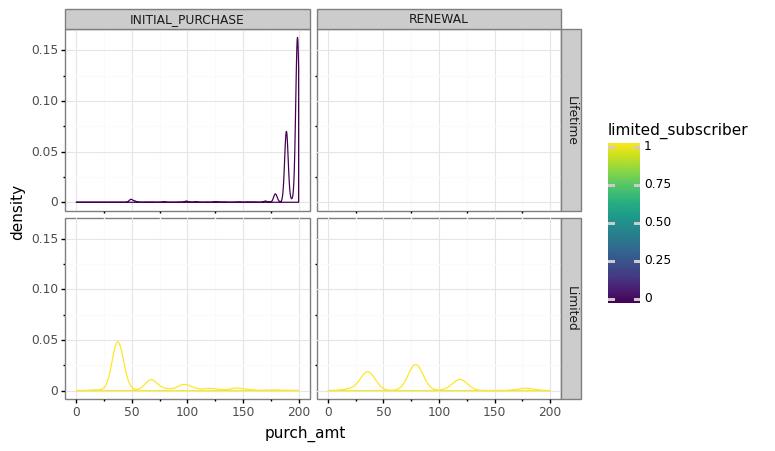

<ggplot: (8789060381925)>

In [ ]:
(ggplot(subscribers_USD, aes(x='purch_amt', color = 'limited_subscriber')) + geom_density() + theme_bw() + 
 xlim(0,200) + facet_grid("subscription_type ~ subscription_event_type"))



```
Rosetta Stone offers 3 mo, 12 mo, and Lifetime subscriptions
Normally about $35, $144, $199
Currently about $35, $96, and $149 for Black Friday Deal
```



In [ ]:
subs_2018 = subscribers_USD['subscription_start'] <= '12/31/2018'
subsc_USD_18 = subscribers_USD[subs_2018]

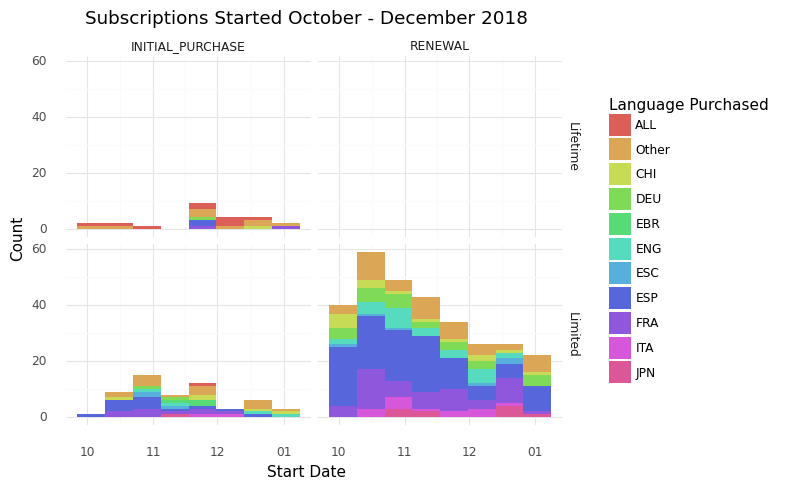

<ggplot: (8789062157917)>

In [ ]:
(ggplot(subsc_USD_18, aes(x = "subscription_start", fill = "language_10")) + geom_histogram() + theme_minimal() + 
 labs(title = "Subscriptions Started October - December 2018", fill = "Language Purchased", x = "Start Date", y = "Count") +
 facet_grid("subscription_type ~ subscription_event_type") + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%m')) )

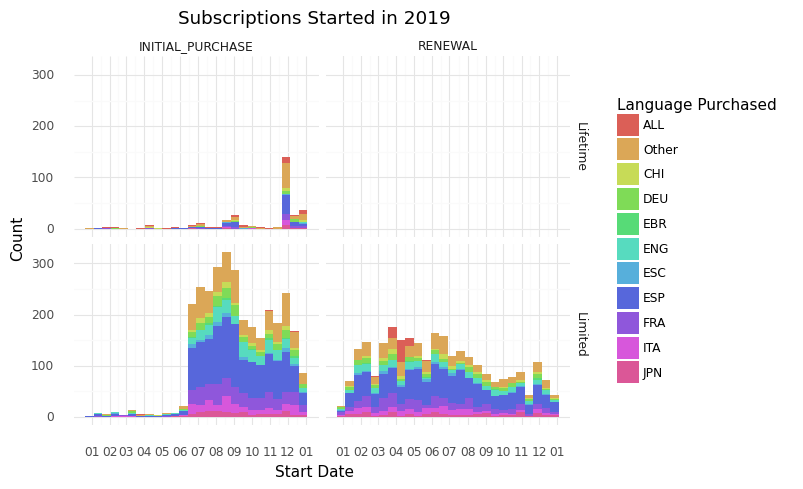

<ggplot: (8789060152917)>

In [ ]:
subs_2019 = ((subscribers_USD['subscription_start'] <= '12/31/2019') & (subscribers_USD['subscription_start'] > '12/31/2018'))

subsc_USD_19 = subscribers_USD[subs_2019]
(ggplot(subsc_USD_19, aes(x = "subscription_start", fill = "language_10")) + geom_histogram() + theme_minimal() + 
 labs(title = "Subscriptions Started in 2019",  fill = "Language Purchased", x = "Start Date", y = "Count") +
 facet_grid("subscription_type ~ subscription_event_type") + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%m')) )

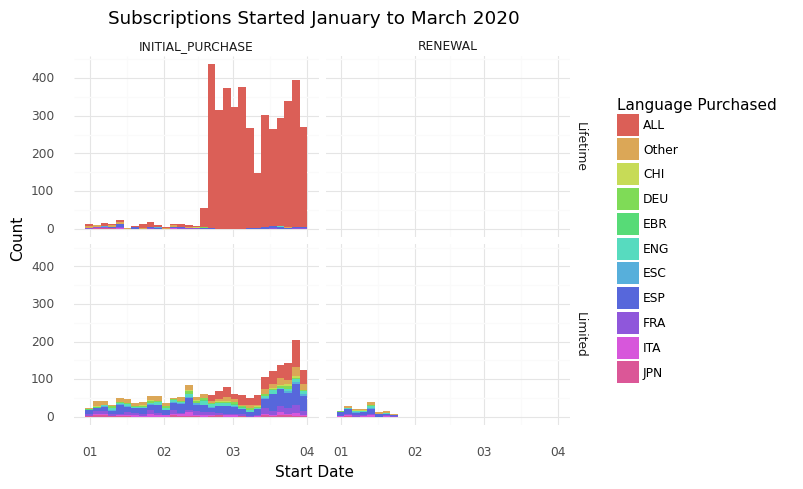

<ggplot: (8789062333313)>

In [ ]:

subs_2020 = ((subscribers_USD['subscription_start'] <= '12/31/2020') & (subscribers_USD['subscription_start'] > '12/31/2019'))

subsc_USD_20 = subscribers_USD[subs_2020]
(ggplot(subsc_USD_20, aes(x = "subscription_start", fill = "language_10")) + geom_histogram() + theme_minimal() + 
 labs(title = "Subscriptions Started January to March 2020", fill = "Language Purchased", x = "Start Date", y = "Count") +
 facet_grid("subscription_type ~ subscription_event_type") + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%m')))

# additional products

In [ ]:
linmod = Ridge(alpha=0.1)
KF = RepeatedKFold(n_splits = 10, n_repeats= 3, random_state = 1)


newpreds = ['demo_user','free_trial_user','email_subscriber','push_notifs','emails_sent', 'emails_opened',
         'emails_clicked', 'unique_emails_opened', 'unique_click_count','ARA', 'CHI', 'DAR',
         'DEU', 'EBR', 'ENG', 'ESC', 'ESP', 'FAR', 'FRA', 'GLE', 'GRK', 'HEB',
         'HIN', 'IND', 'ITA', 'JPN', 'KIS', 'KOR', 'LAT', 'NED', 'PAS', 'POL',
         'POR', 'RUS', 'SVE', 'TGL', 'TUR', 'URD', 'VIE','INITIAL_PURCHASE','webstore',
         'BRL', 'CAD', 'EUR', 'GBP', 'NOK', 'SAR','USD', 'ZAR', 'Europe', 'US/Canada','Consumer',
         'App', 'Web']
newvars = ['demo_user','free_trial_user','email_subscriber','push_notifs','emails_sent', 'emails_opened',
         'emails_clicked', 'unique_emails_opened', 'unique_click_count','ARA', 'CHI', 'DAR',
         'DEU', 'EBR', 'ENG', 'ESC', 'ESP', 'FAR', 'FRA', 'GLE', 'GRK', 'HEB',
         'HIN', 'IND', 'ITA', 'JPN', 'KIS', 'KOR', 'LAT', 'NED', 'PAS', 'POL',
         'POR', 'RUS', 'SVE', 'TGL', 'TUR', 'URD', 'VIE','INITIAL_PURCHASE','webstore',
         'BRL', 'CAD', 'EUR', 'GBP', 'NOK', 'SAR','USD', 'ZAR', 'Europe', 'US/Canada','Consumer',
         'App', 'Web', 'subscription_len']

subscribers_vars = subscribers_full[newvars]
subscribers_vars = subscribers_vars.dropna()

X = subscribers_vars[newpreds]
X = X.dropna()
y = subscribers_vars['subscription_len']
y = y.dropna()
#z = StandardScaler()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)


In [ ]:
linmod.fit(X_train,y_train)
pred = linmod.predict(X_test)


r2_score(y_test,pred)

0.6367719231717828

In [ ]:
dfcoefs = pd.DataFrame({"Coef":linmod.coef_, "Name":preds})
dfcoefs = dfcoefs.sort_values("Coef", ascending = False)
dfcoefs

ValueError: ignored

In [ ]:
from sklearn.linear_model import RidgeClassifier
modie = RidgeClassifier()
KF = RepeatedKFold(n_splits = 15, n_repeats= 3, random_state = 1)


npreds = ['demo_user','free_trial_user','email_subscriber','push_notifs','emails_sent', 'emails_opened',
         'emails_clicked', 'unique_emails_opened', 'unique_click_count','ARA', 'CHI', 'DAR',
         'DEU', 'EBR', 'ENG', 'ESC', 'ESP', 'FAR', 'FRA', 'GLE', 'GRK', 'HEB',
         'HIN', 'IND', 'ITA', 'JPN', 'KIS', 'KOR', 'LAT', 'NED', 'PAS', 'POL',
         'POR', 'RUS', 'SVE', 'TGL', 'TUR', 'URD', 'VIE','INITIAL_PURCHASE','webstore', 'Europe', 'US/Canada','Consumer',
         'App', 'Web']
vars = ['demo_user','free_trial_user','email_subscriber','push_notifs','emails_sent', 'emails_opened',
         'emails_clicked', 'unique_emails_opened', 'unique_click_count','ARA', 'CHI', 'DAR',
         'DEU', 'EBR', 'ENG', 'ESC', 'ESP', 'FAR', 'FRA', 'GLE', 'GRK', 'HEB',
         'HIN', 'IND', 'ITA', 'JPN', 'KIS', 'KOR', 'LAT', 'NED', 'PAS', 'POL',
         'POR', 'RUS', 'SVE', 'TGL', 'TUR', 'URD', 'VIE','INITIAL_PURCHASE','webstore',
         'BRL', 'CAD', 'EUR', 'GBP', 'USD', 'Europe', 'US/Canada','Consumer',
         'App', 'Web', 'limited_subscriber', 'auto_renew']

subscribers_vars = subscribers_limited[vars]
subscribers_vars = subscribers_vars.dropna()

X = subscribers_vars[npreds]
X = X.dropna()
y = subscribers_vars['auto_renew']
y = y.dropna()
#z = StandardScaler()
X_train1,X_test1,y_train1,y_test1 = train_test_split(X,y,test_size = 0.2)

# I am not z-scoring the variables so we can discuss the numerical variables by increase in unit instead of standard deviation
#Since this will need to be interpretable for a general business audience


#X_train[preds] = z.fit_transform(X_train[preds])
#X_test[preds] = z.fit_transform(X_test[preds])

X_train.info()

In [ ]:
modie.fit(X_train, y_train)

In [ ]:

prob2=modie.predict(X_test)
predicted3=[1 if i > 0.5 else 0 for i in prob2]
accuracy_score(y_test, predicted3)

In [ ]:
coefdf2 = pd.DataFrame({"Coefs": modie.coef_[0], "names":X_train.columns})
#coefdf1 = coefdf1.append({"Coefs": modie.intercept_[0], "names": "intercept"},ignore_index = True)

coefdf2['Odds'] = np.exp(coefdf2["Coefs"])
sorted1 = coefdf2.sort_values(by = ['Coefs'], ascending=False)
sorted1.head(30)